In [0]:
import pandas as pd
import glob
import math

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')
#SVR sklearn
#Per el dia 3 enviar un report del que he anat fent.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [0]:
PATH_TO_DATA = '/content/drive/My Drive/MATT/MLEARN/MLEARN.zip (Unzipped Files)/MLEARN/00Data'

In [0]:
data = pd.read_csv(PATH_TO_DATA+'/Generated/DB20191209.csv')

In [0]:
print(data.dtypes.unique())

[dtype('int64') dtype('float64') dtype('O')]


In [0]:
data.head()

,Unnamed: 0,B365H,B365D,B365A,Date,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0,2.2,3.2,3.50,26/08/2016,Betis,La Coruna,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,71.400000,75.0,79.0,74.818182,76.0,81.0,73.678571,75.5,81.0,73.666667,70.0,78.181818,78.0,60.0,1.000000,2.0,2.0,2,1.0,1.0,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0
1,1,2.3,3.1,3.40,26/08/2016,Espanol,Malaga,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,73.000000,75.0,79.0,75.300000,77.0,82.0,74.250000,76.5,82.0,75.000000,79.0,78.454545,78.0,64.0,0.333333,1.0,1.0,1,1.0,1.0,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0
2,2,2.7,3.2,2.75,27/08/2016,Eibar,Valencia,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,70.500000,72.5,79.0,73.900000,77.0,79.0,71.870968,75.0,75.0,68.500000,69.5,77.545455,78.0,60.0,0.000000,2.0,2.0,2,4.0,4.0,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0
3,3,8.5,3.6,1.53,27/08/2016,Leganes,Ath Madrid,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,69.500000,71.0,77.0,73.500000,74.0,77.0,71.939394,73.0,76.0,71.750000,73.0,76.181818,76.0,61.0,0.333333,1.0,1.0,1,1.0,1.0,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75

In [0]:
data['B365H'] = 1/data['B365H']
data['B365D'] = 1/data['B365D']
data['B365A'] = 1/data['B365A']


In [0]:
data = data.drop(columns=['Unnamed: 0','Date','HomeTeam','AwayTeam'])

In [0]:
data.shape

(1199, 95)

In [0]:
data['Sum'] = data['B365H'] + data['B365D'] + data['B365A'] 
data['B365H'] = data['B365H']/data['Sum']
data['B365D'] = data['B365D']/data['Sum']
data['B365A'] = data['B365A']/data['Sum']


In [0]:
data['Sum'] = data['B365H'] + data['B365D'] + data['B365A'] 

In [0]:
del data['Sum']

In [0]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,0].name

In [0]:
len(features)

92

In [0]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [0]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
HomeTeam_TopOverallMean vs B365H,0.686543
HomeTeam_TopOverallMedian vs B365H,0.684307
HomeTeam_OverallMax vs B365H,0.666996
HomeTeam_DefensaMax vs B365H,0.659385
HomeTeam_DelanteroMax vs B365H,0.654132
AwayTeam_TopOverallMean vs B365H,-0.642159
HomeTeam_Wins_season vs B365H,0.640905
AwayTeam_TopOverallMedian vs B365H,-0.640158
HomeTeam_Points vs B365H,0.639985
HomeTeam_OverallMedian vs B365H,0.637047


In [0]:
X = data.iloc[:,3:]

In [0]:
X.head()

,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,71.400000,75.0,79.0,74.818182,76.0,81.0,73.678571,75.5,81.0,73.666667,70.0,78.181818,78.0,60.0,1.000000,2.0,2.0,2,1.0,1.0,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0
1,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,73.000000,75.0,79.0,75.300000,77.0,82.0,74.250000,76.5,82.0,75.000000,79.0,78.454545,78.0,64.0,0.333333,1.0,1.0,1,1.0,1.0,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0
2,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,70.500000,72.5,79.0,73.900000,77.0,79.0,71.870968,75.0,75.0,68.500000,69.5,77.545455,78.0,60.0,0.000000,2.0,2.0,2,4.0,4.0,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0
3,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,69.500000,71.0,77.0,73.500000,74.0,77.0,71.939394,73.0,76.0,71.750000,73.0,76.181818,76.0,61.0,0.333333,1.0,1.0,1,1.0,1.0,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75.666667,80.0,84.0,76.416667,80.5,88.0,76.548387,81.0,87.0,75.750000,75.5,84.636364,84.0,61.0
4,0.333333,1.0,1.0,1,1.0,1.0,1,20,7,1,8,7,15,22,5,3,8,32,1.210526,1.0,3,1,0.736842,1.0,3,0,26.030303,27.0,75.0,71.727273,72.0,76

In [0]:
X.describe()

,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,0.450345,1.337580,1.173478,3.608841,1.356764,1.170559,3.762302,10.403670,9.054212,5.505421,14.559633,5.386155,9.046706,14.432861,4.559633,4.447873,9.007506,52.686405,1.589044,1.451209,4.231026,1.177648,1.177692,1.049208,3.617181,0.688907,25.184992,24.843203,80.154295,73.990881,75.724771,81.135113,74.047992,75.091326,81.087573,74.504779,75.872811,82.574646,73.985456,75.939116,79.761468,72.892369,73.620100,79.376526,79.040867,61.557965,0.458098,1.359763,1.190575,3.638866,1.342859,1.167640,3.739783,10.355296,9.055046,5.529608,14.584654,5.372811,9.007506,14.380317,4.572143,4.462886,9.035029,52.788991,1.593960,1.456214,4.237698,1.183486,1.180633,1.050042,3.628023,0.688073,25.183959,24.838198,80.201835,74.018919,75.761468,81.185154,74.108389,75.164304,81.129274,74.530703,75.879900,82.608007,74.017712,75.967890,79.7

In [0]:
y = data.iloc[:,:3]

In [0]:
y.head()

,B365H,B365D,B365A
0,0.431766,0.296839,0.271396
1,0.413495,0.306787,0.279718
2,0.353911,0.298613,0.347476
3,0.112150,0.264798,0.623053
4,0.308642,0.308642,0.382716


In [0]:
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X)
X2 = pd.DataFrame(data = principalComponents)

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)


In [0]:
xg_reg = MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10))

In [0]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[18:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.127119


In [0]:
for components in [3,5,10,15,30,50]:
  pca = PCA(n_components=components)
  principalComponents = pca.fit_transform(X)
  X2 = pd.DataFrame(data = principalComponents)
  X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
  xg_reg = MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10))
  xg_reg.fit(X_train,y_train)
  preds = xg_reg.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, preds))
  print("RMSE amb " + str(components) + " components: " + str(rmse))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
xg_reg = MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
              max_depth = 5, alpha = 10, n_estimators = 10))
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE sense PCA: " + str(rmse))

[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE amb 3 components: 0.13112091977801948
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE amb 5 components: 0.1455221397624445
[18:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:24] WARNING: /works

In [0]:
svr = MultiOutputRegressor(SVR(kernel='linear', C=10,cache_size=7000, gamma=0.1, epsilon=.1))

In [0]:
svr.fit(X_train,y_train)

preds = svr.predict(X_test)

[LibSVM][LibSVM][LibSVM]Algo ha fet


In [0]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2.019784


In [0]:
res = y_test.copy()

In [0]:
res['P_B365H'] = preds[:,0]
res['P_B365D'] = preds[:,1]
res['P_B365A'] = preds[:,2]

In [0]:
res

,B365H,B365D,B365A,P_B365H,P_B365D,P_B365A
464,0.634039,0.219644,0.146317,0.552364,0.338004,0.292452
602,0.473492,0.270567,0.255941,0.507241,0.350892,0.339515
487,0.238638,0.245387,0.515975,0.274329,0.315842,0.568272
189,0.744048,0.191964,0.063988,0.679443,0.277448,0.224893
1018,0.365854,0.317073,0.317073,0.436241,0.357281,0.407239
935,0.228137,0.239544,0.532319,0.303340,0.327655,0.531994
202,0.677591,0.210806,0.111603,0.596852,0.309438,0.245614
1145,0.515668,0.293534,0.190797,0.535023,0.337172,0.294764
868,0.173596,0.280817,0.545587,0.312484,0.358588,0.491953
401,0.629213,0.235955,0.134831,0.557210,0.330894,0.286070


In [0]:
print(res['P_B365H'].min())
print(res['P_B365D'].min())
print(res['P_B365A'].min())

0.24952271580696106
0.24977362155914307
0.22020787000656128


In [0]:
print(res['P_B365H'].max())
print(res['P_B365D'].max())
print(res['P_B365A'].max())

0.7260533571243286
0.3614380359649658
0.665172815322876


In [0]:
print(res['B365H'].min())
print(res['B365D'].min())
print(res['B365A'].min())

0.07322929171668667
0.06358535933742988
0.023374888691006235


In [0]:
print(res['B365H'].max())
print(res['B365D'].max())
print(res['B365A'].max())

0.9127337488869101
0.328952672740466
0.7985257985257985


In [0]:
res['PredProb'] = 100/res['P_B365H']+ 100/res['P_B365D'] + 100/res['P_B365A']
res['Prob'] = 100/res['B365H']+ 100/res['B365D'] + 100/res['B365A']

In [0]:
res['Diff'] = res['PredProb'] - res['Prob']
res['AbsDiff'] = abs(res['Diff'])

In [0]:
res['Diff'] = res['B365H'] - res['Prediction']
res['AbsDiff'] = abs(res['Diff'])

In [0]:
res.describe()

,B365H,B365D,B365A,P_B365H,P_B365D,P_B365A,PredProb,Prob,Diff,AbsDiff
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2.926792,4.257583,5.372917,2.689193,3.983046,4.934620,114.483101,105.159102,9.323999,66.744094
std,2.427298,1.747073,5.396950,1.926313,1.530150,3.921940,172.959599,0.528226,172.944116,159.760929
min,1.050000,2.870000,1.200000,-0.772216,0.801548,-3.183952,-1621.192022,103.942652,-1726.173225,0.026314
25%,1.610000,3.300000,2.500000,1.405858,2.936688,2.300364,92.152567,104.823285,-12.897258,9.623953
50%,2.100000,3.600000,3.600000,2.167544,3.717781,3.894160,110.970994,105.058275,5.819525,23.772972
75%,2.892500,4.330000,5.500000,3.392396,4.642865,6.618223,145.779962,105.362904,40.562723,56.320852
max,13.000000,15.000000,41.000000,8.769529,9.328943,19.181889,1161.883512,107.192522,1056.749018,1726.173225


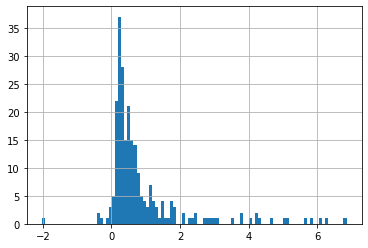

In [0]:
res['Diff'].hist(bins=100)

In [0]:
for dif in [0.01, 0.05, 0.1, 0.2, 0.5, 1]:
  print('En un '+str(sum(res['AbsDiff']>dif)*100/len(res))+'% dels casos, la predicció falla per més d\'un '+str(dif))

En un 99.16666666666667% dels casos, la predicció falla per més d'un 0.01
En un 98.33333333333333% dels casos, la predicció falla per més d'un 0.05
En un 96.25% dels casos, la predicció falla per més d'un 0.1
En un 87.08333333333333% dels casos, la predicció falla per més d'un 0.2
En un 51.25% dels casos, la predicció falla per més d'un 0.5
En un 23.75% dels casos, la predicció falla per més d'un 1


In [0]:
def keyfunction(k):
    return d[k]

d= xg_reg.get_booster().get_score(importance_type="gain")
# sort by dictionary by the values and print top 3 {key, value} pairs
for key in sorted(d, key=keyfunction, reverse=True)[:10]:
    print ('%s: %i' % (key, d[key]))

AwayTeam_Wins_season: 1510
AwayTeam_Points: 1064
AwayTeam_Away_Wins_season: 548
HomeTeam_DefensaMean: 330
AwayTeam_OverallMax: 315
HomeTeam_OverallMedian: 279
AwayTeam_Lose_season: 141
AwayTeam_Position: 113
AwayTeam_PorteroMax: 91
HomeTeam_DefensaMax: 80


In [0]:
xg_reg.get_booster().get_score(importance_type="gain")

{'AwayTeamGolsContraMax': 2.101381781,
 'AwayTeamGolsContraMean': 4.61090088,
 'AwayTeamGolsFavorMax': 4.32582092,
 'AwayTeamGolsFavorMean': 63.96146646666667,
 'AwayTeamGolsFavorMedian': 8.19429016,
 'AwayTeamPercPoints': 6.862504148571429,
 'AwayTeam_Away_Wins_season': 548.721406555,
 'AwayTeam_Away_goals_max': 51.75134275,
 'AwayTeam_DefensaMax': 8.113959941166668,
 'AwayTeam_DelanteroMedian': 31.0793457,
 'AwayTeam_Draw_season': 4.389312745,
 'AwayTeam_Home_Lose_season': 0.962997437,
 'AwayTeam_Home_Wins_season': 0.758679388,
 'AwayTeam_Home_goals_max': 0.08852911,
 'AwayTeam_Home_goals_med': 2.2350769,
 'AwayTeam_Home_goals_mode': 17.0256348,
 'AwayTeam_Lose_season': 141.97798421333334,
 'AwayTeam_MedioMean': 49.9904175,
 'AwayTeam_MedioMedian': 9.49630737,
 'AwayTeam_OverallMax': 315.09560548400003,
 'AwayTeam_OverallMean': 1.749364218,
 'AwayTeam_OverallMedian': 4.600128175,
 'AwayTeam_Points': 1064.2524182425,
 'AwayTeam_PorteroMax': 91.2072754,
 'AwayTeam_PorteroMean': 0.32490

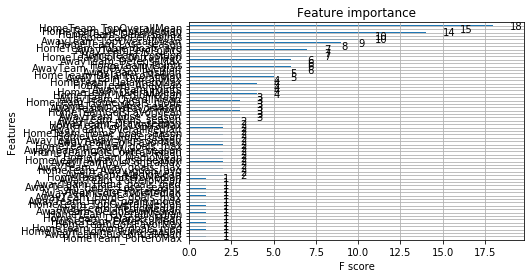

In [0]:
a = xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
plt.show()